# Neural Particles 2D

## 2D Dataset
Pipeline:
* Generation of high-res data (reference) using some random cubes of water
* Extracting relevant data (particle data and grid data) like e.g. sdf, velocity, pressure, density...
* Down-sampling of particles (by a given factor) and generation of the low-res data (source)
* Extract corresponding and relevant patches on the surface from the data-set pairs (considering the low-res data)
* Use patche-pairs to train the NN

### Load Config

**Main Config**

In [5]:
import sys
sys.path.append("manta/scenes/tools")
import json
import os

def print_config(config, desc):
    print("{:<20} {:<25} {:<10}\n".format("key", "value", "description"))
    for k, v in config.items():
        print("{:<20} {:<25} {:<10}".format(k, str(v), desc[k]))

config_path = "config/version_02.txt"
data_path = "2d_data/"
dataset = 19

with open(config_path, 'r') as f:
    config = json.loads(f.read())

print_config(config, {
        "preprocess" : "pre-processing config location",
        "id" : "id of the config version",
        "data" : "data config location",
        "train" : "train config location"
    })


key                  value                     description

data                 data/data_00.txt          data config location
preprocess           preprocess/pre_00.txt     pre-processing config location
train                train/train_01.txt        train config location
id                   v02                       id of the config version


**Data Config**

In [6]:
with open(os.path.dirname(config_path) + '/' + config['data'], 'r') as f:
    data_config = json.loads(f.read())
print_config(data_config, {
        "id":             "id of the config version",
        "prefix":         "prefix of the generated data",
        "fps":            "frames per second, the velocity of the simulation",
        "frame_count":    "count of generated frames",
        "data_count":     "count of generated datasets",
        "sub_res":        "count of particles per cell (per dimension)",
        "res":            "resolution of high-res grid",
        "var1":           "factor of drop falling in basin data-sets (var0 is 1 - var1 - var2)",
        "var2":           "factor of two drop shooting against other",
        "seed":           "seed for random data-set generation",
        "min_scale":      "minimum scale of boxes for data-set generation",
        "max_scale":      "maximum scale of boxes for data-set generation",
        "min_pos":        "minimum x-position of boxes",
        "max_pos":        "maximum x-position of boxes",
        "max_h":          "maximum start-height of boxes",
        "max_cnt":        "maximum count of boxes",
        "circ_vel":       "velocity used for colliding drops"
    })

key                  value                     description

max_h                0.1                       maximum start-height of boxes
seed                 123412144                 seed for random data-set generation
var1                 0.5                       factor of drop falling in basin data-sets (var0 is 1 - var1 - var2)
data_count           20                        count of generated datasets
frame_count          20                        count of generated frames
id                   dat00                     id of the config version
fps                  30                        frames per second, the velocity of the simulation
circ_vel             100.0                     velocity used for colliding drops
max_scale            0.3                       maximum scale of boxes for data-set generation
min_scale            0.05                      minimum scale of boxes for data-set generation
max_cnt              5                         maximum count of boxes
min_pos  

**Pre-process Config**

In [7]:
with open(os.path.dirname(config_path) + '/' + config['preprocess'], 'r') as f:
    pre_config = json.loads(f.read())
print_config(pre_config, {
        "id":             "id of the config version",
        "patch_size":     "size of generated surface patches (of the low-res data)",
        "stride":         "stride used for the generation of the patches",
        "surf":           "surface tolerance, specifies where to extract the patches",
        "l_fac":          "multiplicative factor of low-res sdf-patches",
        "h_fac":          "multiplicative factor of high-res sdf-patches",
        "use_tanh":       "apply tanh on sdf-patches, after multiplication with factor",
        "factor":         "goal up-scale factor of particles",
        "min_n":          "minimum amount of neighbors used for down-sampling",
        "var":            "count of down-samplings of the same data-set with different seeds",
        "par_cnt":        "particle count for each patch"
    })

key                  value                     description

var                  1                         count of down-samplings of the same data-set with different seeds
use_tanh             1                         apply tanh on sdf-patches, after multiplication with factor
h_fac                4.0                       multiplicative factor of high-res sdf-patches
l_fac                12.0                      multiplicative factor of low-res sdf-patches
id                   p00                       id of the config version
factor               9                         goal up-scale factor of particles
min_n                0                         minimum amount of neighbors used for down-sampling
surf                 0.5                       surface tolerance, specifies where to extract the patches
stride               2                         stride used for the generation of the patches
par_cnt              10                        particle count for each patch
patch_siz

**Train Config**

In [8]:
with open(os.path.dirname(config_path) + '/' + config['train'], 'r') as f:
    train_config = json.loads(f.read())
print_config(train_config, {
        "id":                 "id of the config version",
        "train_split":        "split ratio for train and test data",
        "val_split":          "split ratio for train and validation data",
        "t_start":            "timestep start-point of data",
        "t_end":              "timestep end-point of data",
        "features":           "list of strings which the features used by the neural network",
        "batch_size":         "batch size used for training and validation",
        "learning_rate":      "learing rate used for training",
        "epochs":             "training epochs",
        "explicit":           "specify if use a lagrangian- or eulerian-based network",
        "mse_fac":            "MSE loss factor",
        "adv_fac":            "adversarial loss factor, if bigger then one a GAN architecture is used"
    })

key                  value                     description

learning_rate        0.001                     learing rate used for training
adv_fac              0.01                      adversarial loss factor, if bigger then one a GAN architecture is used
id                   t01                       id of the config version
explicit             False                     specify if use a lagrangian- or eulerian-based network
epochs               250                       training epochs
batch_size           32                        batch size used for training and validation
t_start              5                         timestep start-point of data
t_end                15                        timestep end-point of data
train_split          0.9                       split ratio for train and test data
features             ['sdf', 'vel']            list of strings which the features used by the neural network
mse_fac              1.0                       MSE loss factor
val_split  

### Reference Data (High Resolution)

In [9]:
from subprocess import Popen, PIPE 
from IPython.display import Image

def run_python(script,param):
    command = ["python3",script]
    for k,v in param.items():
        command += [k, str(v)]
    print(" ".join(command))
    
    proc = Popen(command, stdin=None, stdout=PIPE, stderr=PIPE)

    for line in proc.stderr:
        print(line.decode('utf-8'))

if not os.path.exists("tmp"):
    os.makedirs("tmp")
    
param = {
    "data" : data_path,
    "manta" : "manta/",
    "config" : config_path,
    "verbose" : 0,
    "t_start" : train_config["t_end"]-1,
    "t_end" : train_config["t_end"],
    "dataset" : dataset,
    "var": 0,
    "type": "ref",
    "scr" : "tmp/ref.png"
}

run_python("show_data.py",param)

python3 show_data.py verbose 0 config config/version_02.txt data 2d_data/ t_end 15 manta manta/ t_start 14 var 0 dataset 19 scr tmp/ref.png type ref


<img src="tmp/ref.png" width="400"/> 

### Reference Data (Low Resolution)

In [90]:
param = {
    "data" : data_path,
    "manta" : "manta/",
    "config" : config_path,
    "verbose" : 0,
    "t_start" : train_config["t_end"]-1,
    "t_end" : train_config["t_end"],
    "dataset" : dataset,
    "var": 0,
    "type": "real",
    "scr" : "tmp/real.png"
}

run_python("show_data.py",param)

python3 show_data.py t_start 14 scr tmp/real.png manta manta/ var 0 t_end 15 type real dataset 19 data 2d_data/ config config/version_03.txt verbose 0


<img src="tmp/real.png" width="400"/> 

### Source Data (Low Resolution)

In [91]:
param = {
    "data" : data_path,
    "manta" : "manta/",
    "config" : config_path,
    "verbose" : 0,
    "t_start" : train_config["t_end"]-1,
    "t_end" : train_config["t_end"],
    "dataset" : dataset,
    "var": 0,
    "type": "src",
    "scr" : "tmp/src.png"
}

run_python("show_data.py",param)

python3 show_data.py t_start 14 scr tmp/src.png manta manta/ var 0 t_end 15 type src dataset 19 data 2d_data/ config config/version_03.txt verbose 0


<img src="tmp/src.png" width="400"/> 

### Extracted Patches

In [92]:
param = {
    "data" : data_path,
    "manta" : "manta/",
    "config" : config_path,
    "verbose" : 0,
    "timestep" : train_config["t_end"]-1,
    "dataset" : dataset,
    "var": 0,
    "l_scr" : "tmp/src_patch_%02d.png",
    "h_scr" : "tmp/ref_patch_%02d.png"
}

run_python("show_patches.py",param)

python3 show_patches.py manta manta/ timestep 14 h_scr tmp/ref_patch_%02d.png var 0 l_scr tmp/src_patch_%02d.png dataset 19 data 2d_data/ config config/version_03.txt verbose 0


<img src="tmp/src_patch_29.png" width="400"/> 
<img src="tmp/ref_patch_29.png" width="400"/> 

### Neural Network

**Model**

In [10]:
import keras
from keras.models import load_model
from subpixel import *

model_path = '%s%s_%s' % (data_path + "models/", data_config['prefix'], config['id'])
print(model_path + ".h5")
load_model(model_path + ".h5", custom_objects={'Subpixel': Subpixel}).summary()

Using TensorFlow backend.


2d_data/models/sph_2D_v02.h5
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 5, 5, 1)      0                                            
__________________________________________________________________________________________________
auxiliary_input (InputLayer)    (None, 5, 5, 3)      0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 5, 5, 4)      0           main_input[0][0]                 
                                                                 auxiliary_input[0][0]            
__________________________________________________________________________________________________
reshape_flat_res (Reshape)      (None, 100)          0           concatenate[0][

**Loss**

2d_data/models/sph_2D_v02_loss.png


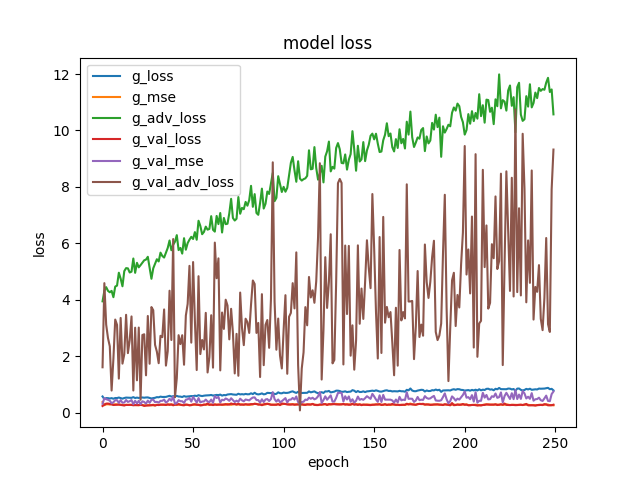

In [13]:
fig_path = '%s_loss.png' % model_path
print(fig_path)
Image(filename=fig_path, width=400) 

### Results

In [14]:
# run network
param = {
    "data" : data_path,
    "config" : config_path,
    "verbose" : 0,
    "t_start" : train_config["t_start"],
    "t_end" : train_config["t_end"],
    "dataset" : dataset,
    "var": 0
}

run_python("run.py",param)

python3 run.py verbose 0 config config/version_02.txt data 2d_data/ t_end 15 t_start 5 var 0 dataset 19
2017-12-04 22:23:19.656816: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.

2017-12-04 22:23:19.656840: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.

2017-12-04 22:23:19.656854: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU computations.

2017-12-04 22:23:19.656861: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use FMA instructions, but these are available on your machine and could speed up CPU computations.

Usin

In [15]:
param = {
    "data" : data_path,
    "manta" : "manta/",
    "config" : config_path,
    "verbose" : 0,
    "t_start" : train_config["t_start"],
    "t_end" : train_config["t_end"],
    "dataset" : dataset,
    "var": 0,
    "type": "res",
    "scr" : "tmp/res_%03d.png"
}

run_python("show_data.py",param)

python3 show_data.py verbose 0 config config/version_02.txt data 2d_data/ t_end 15 manta manta/ t_start 5 var 0 dataset 19 scr tmp/res_%03d.png type res


<img src="tmp/res_014.png" width="400"/> 

In [16]:
# run network
param = {
    "data" : data_path,
    "src" : data_path + "real/%s_%s_d%03d" % (data_config['prefix'], data_config['id'], dataset) + "_%03d",
    "config" : config_path,
    "verbose" : 0,
    "t_start" : train_config["t_start"],
    "t_end" : train_config["t_end"],
    "dataset" : dataset,
    "var": 0
}

run_python("run.py",param)

python3 run.py verbose 0 config config/version_02.txt data 2d_data/ t_end 15 src 2d_data/real/sph_2D_dat00_d019_%03d t_start 5 var 0 dataset 19
2017-12-04 22:23:43.981736: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.

2017-12-04 22:23:43.981768: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.

2017-12-04 22:23:43.981773: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU computations.

2017-12-04 22:23:43.981778: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use FMA instructions, but these are available on your machine an

In [17]:
param = {
    "data" : data_path,
    "manta" : "manta/",
    "config" : config_path,
    "verbose" : 0,
    "t_start" : train_config["t_start"],
    "t_end" : train_config["t_end"],
    "dataset" : dataset,
    "var": 0,
    "type": "res_real",
    "scr" : "tmp/real_res_%03d.png"
}

run_python("show_data.py",param)

python3 show_data.py verbose 0 config config/version_02.txt data 2d_data/ t_end 15 manta manta/ t_start 5 var 0 dataset 19 scr tmp/real_res_%03d.png type res_real


<img src="tmp/real_res_014.png" width="400"/> 